In [101]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time


In [119]:
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta
from networks.loss_functions import CrossEntropy, SquareLoss
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization

from helpers.helper import *
from helpers.processing import *

from Channel.parameters import *
from Channel.transmitor import *
from Channel.modulator import *
from Channel.channel import *
from Channel.equalizer import *
from Channel.demodulator import *
from Channel.detector import *
from nnet_Generator.NNetGenerator import *

In [120]:
bandwidth = 1#1e9                       # bandwidth
nsymbols = 16                    # Number of symbols
M = 16                                # size of the constellation
Nt = 2**10                           # Sample size
nLayers = 500                         # Number of Layers of the Generative network
nb = int(nsymbols * np.log2(M))       # Number of bits
timeMesh = int( (nb/bandwidth)+ (10*2/ nb) ) # 40 #70 # int( (nb/bandwidth)+ (10*2/ nb) )

In [121]:
# Initialize parameters
parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
#params = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
# Initialize the Transmitor
transmitor = Transmitor()
# Initialize the Transmitor
modulator = Modulator()
# Initialize the Channel
channel = Channel()
# Initialize the Equalizer
equalizer = Equalizer()
# Initialize the NNetGenerator
nnetGen = NNetGenerator(parameters)

In [122]:
constellation = transmitor.build_constellations(parameters.M) # 16-QAM

In [123]:
constellation

array([-3.-3.j, -3.-1.j, -3.+3.j, -3.+1.j, -1.+1.j, -1.+3.j, -1.-1.j,
       -1.-3.j,  3.-3.j,  3.-1.j,  3.+3.j,  3.+1.j,  1.+1.j,  1.+3.j,
        1.-1.j,  1.-3.j])

In [124]:
b = transmitor.source(parameters.N, parameters.p)
b

array([0, 1, 1, ..., 0, 0, 0])

In [125]:
# Constellation
constellation = transmitor.build_constellations(parameters.M)

#source
source = transmitor.source(parameters.nb , parameters.p)

# symbol sequence
val_s = transmitor.bit_to_symb(source, parameters.M)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 64 and the array at index 1 has size 1

In [126]:
 transmitor.bit_to_symb(b, constellation)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1024 and the array at index 1 has size 1

In [53]:
def evals(model, X_test, y_test, index_pred, opti, train_err, val_err):
    
    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot using "+str(opti))
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()
    
    y_pred = model.predict(X_test[index_pred])
    
    plt.title("Predicted Signal")
    plt.plot(np.squeeze(np.abs(y_pred)))
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()

In [54]:
# np.load is lazy
d300K = np.load('../data/data_4_300K_P2.6e-2.npz')
d100K = np.load('../data/data_5_100K_P2.6e-2.npz')
d90K = np.load('../data/data_1_90K_P6e-2_P5e-2_P2.6e-2.npz')

#### Unfortunately, I can't train with such hue dataset due to hardware limitations...

In [50]:
X = np.concatenate([d300K['X'], d100K['X'], d90K['X']])
y = np.concatenate([d300K['y'], d100K['y'], d90K['y']])

MemoryError: Unable to allocate 4.58 GiB for an array with shape (307200000,) and data type complex128

In [65]:
import gc
gc.collect()

81

In [66]:
X = d100K['X']
y = d100K['y']

In [67]:
t1 = time.time()
# if scaling=True, we are using min-max scaler
df = prepareDataFrame(X, y, scaling=False)
#df.to_csv("../data/data_90K.csv.gz", index=False, compression="gzip")
t2 = time.time()
print("Toral time to prepare the dataframe is : ", t2-t1, " seconds.")

  0%|                                                                             | 64/100000 [00:00<02:37, 633.70it/s]


 [INFO] {fromComplexToReal} runing...

 [INFO] vect_real.shape :  (100000, 2048)


  0%|                                                                             | 43/100000 [00:00<03:54, 425.75it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (100000, 2048)

 [INFO] {fromComplexToReal} runing...

 [INFO] vect_real.shape :  (100000, 2048)


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:12<00:00, 755.89it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (100000, 2048)
{prepareDataFrame} df_.shape :  (100000, 4096)
Toral time to prepare the dataframe is :  253.8880214691162  seconds.


In [71]:
X.shape

(100000, 1024)

In [69]:
#X = df.iloc[:, 2048:4096]
#y = df.iloc[:, 0:2048]
n_samples, n_features = X.shape
n_hidden = 512

In [70]:
withReshape = True
ts = 0.25
X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)

[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (100000, 2048)
y.shape :  (100000, 2048)
X_train.shape :  (75000, 2048, 1)
y_train.shape :  (75000, 2048, 1)
X_test.shape :  (25000, 2048, 1)
y_test.shape :  (25000, 2048, 1)


In [73]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# MLP model

## Small datest (100k)

### Rectangular

In [38]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [39]:
rect_mlp.add(Dense(2048, input_shape=(n_features,)))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())


rect_mlp.add(Dense(1024))
rect_mlp.add(Activation('selu'))
rect_mlp.add(Dropout(0.25))
rect_mlp.add(BatchNormalization())

rect_mlp.add(Dense(n_output))
rect_mlp.add(Activation('selu'))

print ()
rect_mlp.summary(name="MLP")


+-----+
| MLP |
+-----+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 4196352    | (2048,)      |
| Activation (SELU)  | 0          | (2048,)      |
| Dropout            | 0          | (2048,)      |
| BatchNormalization | 4096       | (2048,)      |
| Dense              | 2098176    | (1024,)      |
| Activation (SELU)  | 0          | (1024,)      |
| Dropout            | 0          | (1024,)      |
| BatchNormalization | 2048       | (1024,)      |
| Dense              | 2099200    | (2048,)      |
| Activation (SELU)  | 0          | (2048,)      |
+--------------------+------------+--------------+
Total Parameters: 8399872



In [40]:
num_epochs = 200
batch_size = 256

In [41]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect, val_err_rect = rect_mlp.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  200


[INFO] Training loss on epoch  1  :  0.31625
[INFO] Validation loss on epoch  1  :  0.32026
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.26499
[INFO] Validation loss on epoch  2  :  0.26046
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.25415
[INFO] Validation loss on epoch  3  :  0.25062
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.24794
[INFO] Validation loss on epoch  4  :  0.24631
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.24327
[INFO] Validation loss on epoch  5  :  0.24321
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.23934
[INFO] Validation loss on epoch  6  :  0.24031
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.23613
[INFO] Validation loss on epoch  7  :  0.23838
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.23308
[INFO] Validation loss on epoch  8  :  0.23644
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.23072
[INFO] Validation loss on epoch  9  :  0.23510
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.22821
[INFO] Validation loss on epoch  10  :  0.23403
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.22615
[INFO] Validation loss on epoch  11  :  0.23289
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.22403
[INFO] Validation loss on epoch  12  :  0.23194
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.22201
[INFO] Validation loss on epoch  13  :  0.23120
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.22025
[INFO] Validation loss on epoch  14  :  0.23036
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.21850
[INFO] Validation loss on epoch  15  :  0.22954
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.21670
[INFO] Validation loss on epoch  16  :  0.22886
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.21491
[INFO] Validation loss on epoch  17  :  0.22808
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.21330
[INFO] Validation loss on epoch  18  :  0.22754
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.21196
[INFO] Validation loss on epoch  19  :  0.22716
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.21045
[INFO] Validation loss on epoch  20  :  0.22667
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.20898
[INFO] Validation loss on epoch  21  :  0.22637
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.20765
[INFO] Validation loss on epoch  22  :  0.22603
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.20615
[INFO] Validation loss on epoch  23  :  0.22556
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.20504
[INFO] Validation loss on epoch  24  :  0.22506
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.20366
[INFO] Validation loss on epoch  25  :  0.22503
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.20242
[INFO] Validation loss on epoch  26  :  0.22476
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.20108
[INFO] Validation loss on epoch  27  :  0.22431
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.19994
[INFO] Validation loss on epoch  28  :  0.22402
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.19869
[INFO] Validation loss on epoch  29  :  0.22383
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.19741
[INFO] Validation loss on epoch  30  :  0.22355
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.19658
[INFO] Validation loss on epoch  31  :  0.22339
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.19515
[INFO] Validation loss on epoch  32  :  0.22336
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.19386
[INFO] Validation loss on epoch  33  :  0.22318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.19347
[INFO] Validation loss on epoch  34  :  0.22290
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.19178
[INFO] Validation loss on epoch  35  :  0.22281
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.19092
[INFO] Validation loss on epoch  36  :  0.22289
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.19029
[INFO] Validation loss on epoch  37  :  0.22281
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.18897
[INFO] Validation loss on epoch  38  :  0.22234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.18768
[INFO] Validation loss on epoch  39  :  0.22255
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.18711
[INFO] Validation loss on epoch  40  :  0.22246
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  41  :  0.18613
[INFO] Validation loss on epoch  41  :  0.22220
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  42  :  0.18507
[INFO] Validation loss on epoch  42  :  0.22223
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  43  :  0.18425
[INFO] Validation loss on epoch  43  :  0.22213
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  44  :  0.18324
[INFO] Validation loss on epoch  44  :  0.22191
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  45  :  0.18271
[INFO] Validation loss on epoch  45  :  0.22190
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  46  :  0.18156
[INFO] Validation loss on epoch  46  :  0.22181
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  47  :  0.18061
[INFO] Validation loss on epoch  47  :  0.22182
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  48  :  0.17969
[INFO] Validation loss on epoch  48  :  0.22197
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  49  :  0.17925
[INFO] Validation loss on epoch  49  :  0.22200
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  50  :  0.17818
[INFO] Validation loss on epoch  50  :  0.22195
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  51  :  0.17704
[INFO] Validation loss on epoch  51  :  0.22169
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  52  :  0.17632
[INFO] Validation loss on epoch  52  :  0.22175
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  53  :  0.17542
[INFO] Validation loss on epoch  53  :  0.22169
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  54  :  0.17477
[INFO] Validation loss on epoch  54  :  0.22169
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  55  :  0.17415
[INFO] Validation loss on epoch  55  :  0.22200
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  56  :  0.17314
[INFO] Validation loss on epoch  56  :  0.22142
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  57  :  0.17239
[INFO] Validation loss on epoch  57  :  0.22173
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  58  :  0.17143
[INFO] Validation loss on epoch  58  :  0.22199
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  59  :  0.17104
[INFO] Validation loss on epoch  59  :  0.22165
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  60  :  0.17018
[INFO] Validation loss on epoch  60  :  0.22171
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  61  :  0.16909
[INFO] Validation loss on epoch  61  :  0.22197
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  62  :  0.16854
[INFO] Validation loss on epoch  62  :  0.22201
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  63  :  0.16792
[INFO] Validation loss on epoch  63  :  0.22185
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  64  :  0.16742
[INFO] Validation loss on epoch  64  :  0.22154
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  65  :  0.16634
[INFO] Validation loss on epoch  65  :  0.22183
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  66  :  0.16577
[INFO] Validation loss on epoch  66  :  0.22186
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  67  :  0.16462
[INFO] Validation loss on epoch  67  :  0.22191
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  68  :  0.16460
[INFO] Validation loss on epoch  68  :  0.22174
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  69  :  0.16341
[INFO] Validation loss on epoch  69  :  0.22180
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  70  :  0.16304
[INFO] Validation loss on epoch  70  :  0.22176
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  71  :  0.16261
[INFO] Validation loss on epoch  71  :  0.22207
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  72  :  0.16209
[INFO] Validation loss on epoch  72  :  0.22164
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  73  :  0.16092
[INFO] Validation loss on epoch  73  :  0.22203
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  74  :  0.16043
[INFO] Validation loss on epoch  74  :  0.22177
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  75  :  0.15961
[INFO] Validation loss on epoch  75  :  0.22175
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  76  :  0.15908
[INFO] Validation loss on epoch  76  :  0.22184
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  77  :  0.15857
[INFO] Validation loss on epoch  77  :  0.22219
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  78  :  0.15813
[INFO] Validation loss on epoch  78  :  0.22211
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  79  :  0.15698
[INFO] Validation loss on epoch  79  :  0.22190
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  80  :  0.15643
[INFO] Validation loss on epoch  80  :  0.22215
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  81  :  0.15586
[INFO] Validation loss on epoch  81  :  0.22199
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  82  :  0.15533
[INFO] Validation loss on epoch  82  :  0.22230
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  83  :  0.15499
[INFO] Validation loss on epoch  83  :  0.22210
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  84  :  0.15420
[INFO] Validation loss on epoch  84  :  0.22202
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  85  :  0.15376
[INFO] Validation loss on epoch  85  :  0.22212
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  86  :  0.15314
[INFO] Validation loss on epoch  86  :  0.22218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  87  :  0.15267
[INFO] Validation loss on epoch  87  :  0.22241
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  88  :  0.15183
[INFO] Validation loss on epoch  88  :  0.22225
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  89  :  0.15156
[INFO] Validation loss on epoch  89  :  0.22235
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  90  :  0.15067
[INFO] Validation loss on epoch  90  :  0.22230
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  91  :  0.15014
[INFO] Validation loss on epoch  91  :  0.22234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  92  :  0.14970
[INFO] Validation loss on epoch  92  :  0.22228
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  93  :  0.14932
[INFO] Validation loss on epoch  93  :  0.22252
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  94  :  0.14880
[INFO] Validation loss on epoch  94  :  0.22231
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  95  :  0.14812
[INFO] Validation loss on epoch  95  :  0.22260
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  96  :  0.14749
[INFO] Validation loss on epoch  96  :  0.22253
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  97  :  0.14731
[INFO] Validation loss on epoch  97  :  0.22256
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  98  :  0.14654
[INFO] Validation loss on epoch  98  :  0.22268
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  99  :  0.14617
[INFO] Validation loss on epoch  99  :  0.22276
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  100  :  0.14563
[INFO] Validation loss on epoch  100  :  0.22276
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  101  :  0.14522
[INFO] Validation loss on epoch  101  :  0.22259
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  102  :  0.14425
[INFO] Validation loss on epoch  102  :  0.22271
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  103  :  0.14424
[INFO] Validation loss on epoch  103  :  0.22288
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  104  :  0.14347
[INFO] Validation loss on epoch  104  :  0.22272
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  105  :  0.14322
[INFO] Validation loss on epoch  105  :  0.22295
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  106  :  0.14313
[INFO] Validation loss on epoch  106  :  0.22272
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  107  :  0.14239
[INFO] Validation loss on epoch  107  :  0.22300
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  108  :  0.14200
[INFO] Validation loss on epoch  108  :  0.22274
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  109  :  0.14161
[INFO] Validation loss on epoch  109  :  0.22315
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  110  :  0.14098
[INFO] Validation loss on epoch  110  :  0.22327
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  111  :  0.14014
[INFO] Validation loss on epoch  111  :  0.22306
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  112  :  0.13996
[INFO] Validation loss on epoch  112  :  0.22318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  113  :  0.13978
[INFO] Validation loss on epoch  113  :  0.22318
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  114  :  0.13926
[INFO] Validation loss on epoch  114  :  0.22300
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  115  :  0.13877
[INFO] Validation loss on epoch  115  :  0.22323
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  116  :  0.13859
[INFO] Validation loss on epoch  116  :  0.22332
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  117  :  0.13808
[INFO] Validation loss on epoch  117  :  0.22328
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  118  :  0.13758
[INFO] Validation loss on epoch  118  :  0.22337
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  119  :  0.13725
[INFO] Validation loss on epoch  119  :  0.22357
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  120  :  0.13691
[INFO] Validation loss on epoch  120  :  0.22341
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  121  :  0.13586
[INFO] Validation loss on epoch  121  :  0.22327
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  122  :  0.13593
[INFO] Validation loss on epoch  122  :  0.22335
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  123  :  0.13531
[INFO] Validation loss on epoch  123  :  0.22330
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  124  :  0.13495
[INFO] Validation loss on epoch  124  :  0.22383
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  125  :  0.13477
[INFO] Validation loss on epoch  125  :  0.22367
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  126  :  0.13440
[INFO] Validation loss on epoch  126  :  0.22339
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  127  :  0.13374
[INFO] Validation loss on epoch  127  :  0.22359
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  128  :  0.13359
[INFO] Validation loss on epoch  128  :  0.22371
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  129  :  0.13299
[INFO] Validation loss on epoch  129  :  0.22358
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  130  :  0.13252
[INFO] Validation loss on epoch  130  :  0.22379
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  131  :  0.13261
[INFO] Validation loss on epoch  131  :  0.22393
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  132  :  0.13209
[INFO] Validation loss on epoch  132  :  0.22373
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  133  :  0.13157
[INFO] Validation loss on epoch  133  :  0.22390
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  134  :  0.13145
[INFO] Validation loss on epoch  134  :  0.22394
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  135  :  0.13077
[INFO] Validation loss on epoch  135  :  0.22401
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  136  :  0.13067
[INFO] Validation loss on epoch  136  :  0.22387
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  137  :  0.13023
[INFO] Validation loss on epoch  137  :  0.22392
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  138  :  0.12985
[INFO] Validation loss on epoch  138  :  0.22381
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  139  :  0.12968
[INFO] Validation loss on epoch  139  :  0.22355
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  140  :  0.12923
[INFO] Validation loss on epoch  140  :  0.22401
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  141  :  0.12858
[INFO] Validation loss on epoch  141  :  0.22402
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  142  :  0.12887
[INFO] Validation loss on epoch  142  :  0.22414
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  143  :  0.12824
[INFO] Validation loss on epoch  143  :  0.22413
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  144  :  0.12728
[INFO] Validation loss on epoch  144  :  0.22418
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  145  :  0.12733
[INFO] Validation loss on epoch  145  :  0.22429
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  146  :  0.12720
[INFO] Validation loss on epoch  146  :  0.22402
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  147  :  0.12690
[INFO] Validation loss on epoch  147  :  0.22406
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  148  :  0.12639
[INFO] Validation loss on epoch  148  :  0.22427
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  149  :  0.12633
[INFO] Validation loss on epoch  149  :  0.22442
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  150  :  0.12593
[INFO] Validation loss on epoch  150  :  0.22413
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  151  :  0.12529
[INFO] Validation loss on epoch  151  :  0.22411
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  152  :  0.12520
[INFO] Validation loss on epoch  152  :  0.22445
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  153  :  0.12458
[INFO] Validation loss on epoch  153  :  0.22447
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  154  :  0.12459
[INFO] Validation loss on epoch  154  :  0.22459
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  155  :  0.12439
[INFO] Validation loss on epoch  155  :  0.22454
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  156  :  0.12398
[INFO] Validation loss on epoch  156  :  0.22451
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  157  :  0.12338
[INFO] Validation loss on epoch  157  :  0.22445
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  158  :  0.12338
[INFO] Validation loss on epoch  158  :  0.22450
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  159  :  0.12331
[INFO] Validation loss on epoch  159  :  0.22445
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  160  :  0.12256
[INFO] Validation loss on epoch  160  :  0.22471
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  161  :  0.12238
[INFO] Validation loss on epoch  161  :  0.22468
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  162  :  0.12266
[INFO] Validation loss on epoch  162  :  0.22451
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  163  :  0.12190
[INFO] Validation loss on epoch  163  :  0.22429
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  164  :  0.12173
[INFO] Validation loss on epoch  164  :  0.22443
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  165  :  0.12148
[INFO] Validation loss on epoch  165  :  0.22446
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  166  :  0.12119
[INFO] Validation loss on epoch  166  :  0.22457
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  167  :  0.12056
[INFO] Validation loss on epoch  167  :  0.22464
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  168  :  0.12057
[INFO] Validation loss on epoch  168  :  0.22461
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  169  :  0.12021
[INFO] Validation loss on epoch  169  :  0.22459
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  170  :  0.11998
[INFO] Validation loss on epoch  170  :  0.22484
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  171  :  0.11974
[INFO] Validation loss on epoch  171  :  0.22488
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  172  :  0.11987
[INFO] Validation loss on epoch  172  :  0.22457
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  173  :  0.11931
[INFO] Validation loss on epoch  173  :  0.22462
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  174  :  0.11913
[INFO] Validation loss on epoch  174  :  0.22471
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  175  :  0.11888
[INFO] Validation loss on epoch  175  :  0.22486
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  176  :  0.11862
[INFO] Validation loss on epoch  176  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  177  :  0.11839
[INFO] Validation loss on epoch  177  :  0.22464
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  178  :  0.11781
[INFO] Validation loss on epoch  178  :  0.22492
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  179  :  0.11820
[INFO] Validation loss on epoch  179  :  0.22470
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  180  :  0.11779
[INFO] Validation loss on epoch  180  :  0.22464
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  181  :  0.11728
[INFO] Validation loss on epoch  181  :  0.22475
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  182  :  0.11697
[INFO] Validation loss on epoch  182  :  0.22491
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  183  :  0.11685
[INFO] Validation loss on epoch  183  :  0.22478
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  184  :  0.11648
[INFO] Validation loss on epoch  184  :  0.22504
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  185  :  0.11661
[INFO] Validation loss on epoch  185  :  0.22489
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  186  :  0.11613
[INFO] Validation loss on epoch  186  :  0.22481
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  187  :  0.11586
[INFO] Validation loss on epoch  187  :  0.22468
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  188  :  0.11564
[INFO] Validation loss on epoch  188  :  0.22481
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  189  :  0.11534
[INFO] Validation loss on epoch  189  :  0.22488
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  190  :  0.11528
[INFO] Validation loss on epoch  190  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  191  :  0.11523
[INFO] Validation loss on epoch  191  :  0.22477
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  192  :  0.11498
[INFO] Validation loss on epoch  192  :  0.22496
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  193  :  0.11463
[INFO] Validation loss on epoch  193  :  0.22506
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  194  :  0.11435
[INFO] Validation loss on epoch  194  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  195  :  0.11366
[INFO] Validation loss on epoch  195  :  0.22472
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  196  :  0.11397
[INFO] Validation loss on epoch  196  :  0.22485
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  197  :  0.11365
[INFO] Validation loss on epoch  197  :  0.22499
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  198  :  0.11389
[INFO] Validation loss on epoch  198  :  0.22502
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  199  :  0.11337
[INFO] Validation loss on epoch  199  :  0.22511
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  200  :  0.11319
[INFO] Validation loss on epoch  200  :  0.22515
-------------------------------------------------------------------------------


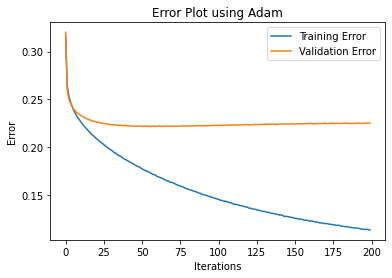

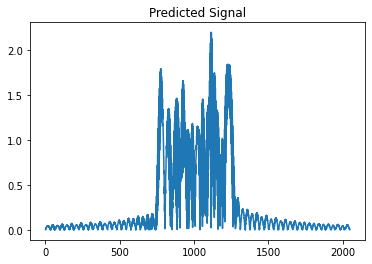

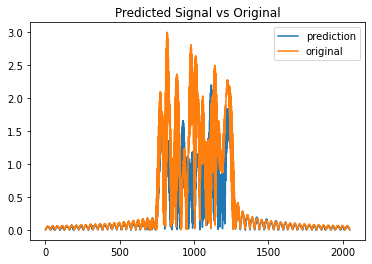

In [42]:
index_pred= 98
evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect)

In [95]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp_deeper = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [96]:
rect_mlp_deeper.add(Dense(2048, input_shape=(n_features,)))
rect_mlp_deeper.add(Activation('myactivation'))
rect_mlp_deeper.add(Dropout(0.25))
rect_mlp_deeper.add(BatchNormalization())


rect_mlp_deeper.add(Dense(2048))
rect_mlp_deeper.add(Activation('sigmoid'))
rect_mlp_deeper.add(Dropout(0.25))
rect_mlp_deeper.add(BatchNormalization())


rect_mlp_deeper.add(Dense(2048))
rect_mlp_deeper.add(Activation('myactivation'))
rect_mlp_deeper.add(Dropout(0.25))
rect_mlp_deeper.add(BatchNormalization())


rect_mlp_deeper.add(Dense(n_output))
rect_mlp_deeper.add(Activation('selu'))

print ()
rect_mlp_deeper.summary(name="MLP-rect-4")


+------------+
| MLP-rect-4 |
+------------+
Input Shape: (2048,)
+---------------------------+------------+--------------+
| Layer Type                | Parameters | Output Shape |
+---------------------------+------------+--------------+
| Dense                     | 4196352    | (2048,)      |
| Activation (MyActivation) | 0          | (2048,)      |
| Dropout                   | 0          | (2048,)      |
| BatchNormalization        | 4096       | (2048,)      |
| Dense                     | 4196352    | (2048,)      |
| Activation (Sigmoid)      | 0          | (2048,)      |
| Dropout                   | 0          | (2048,)      |
| BatchNormalization        | 4096       | (2048,)      |
| Dense                     | 4196352    | (2048,)      |
| Activation (MyActivation) | 0          | (2048,)      |
| Dropout                   | 0          | (2048,)      |
| BatchNormalization        | 4096       | (2048,)      |
| Dense                     | 4196352    | (2048,)      |
| Act

In [97]:
num_epochs = 200
batch_size = 64

In [98]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_rect_deeper, val_err_rect_deeper = rect_mlp_deeper.fit(X_train, y_train, num_epochs, batch_size)

[INFO] Batch size :  64
[INFO] Training epochs number :  200


[INFO] Training loss on epoch  1  :  0.27577
[INFO] Validation loss on epoch  1  :  0.25059
-------------------------------------------------------------------------------


KeyboardInterrupt: 

## Biger dataset (100K)

In [ ]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
rect_mlp_big = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [ ]:
rect_mlp_big.add(Dense(2048, input_shape=(n_features,)))
rect_mlp_big.add(Activation('selu'))
rect_mlp_big.add(Dropout(0.25))
rect_mlp_big.add(BatchNormalization())


rect_mlp_big.add(Dense(1024))
rect_mlp_big.add(Activation('selu'))
rect_mlp_big.add(Dropout(0.25))
rect_mlp_big.add(BatchNormalization())

rect_mlp_big.add(Dense(1024))
rect_mlp_big.add(Activation('selu'))
rect_mlp_big.add(Dropout(0.25))
rect_mlp_big.add(BatchNormalization())

rect_mlp_big.add(Dense(n_output))
rect_mlp_big.add(Activation('selu'))

print ()
rect_mlp_big.summary(name="MLP")

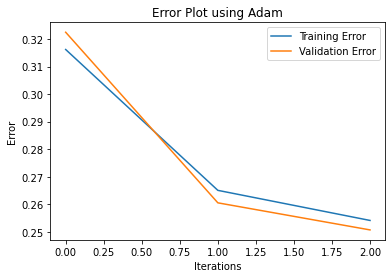

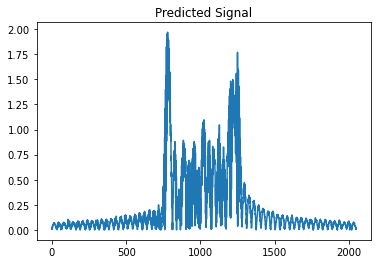

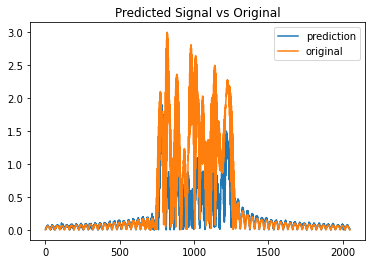

In [32]:
index_pred= 98
evals(rect_mlp, X_test, y_test, index_pred, opti, train_err_rect, val_err_rect)

### Autoencoder like

In [5]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
clf = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [6]:
clf.add(Dense(64, input_shape=(n_features,)))
clf.add(Activation('selu'))
clf.add(Dropout(0.25))
clf.add(BatchNormalization())

clf.add(Dense(32))
clf.add(Activation('selu'))
clf.add(Dropout(0.25))
clf.add(BatchNormalization())

clf.add(Dense(16))
clf.add(Activation('selu'))
clf.add(Dropout(0.25))
clf.add(BatchNormalization())

clf.add(Dense(32))
clf.add(Activation('selu'))
clf.add(Dropout(0.25))
clf.add(BatchNormalization())

clf.add(Dense(64))
clf.add(Activation('selu'))
clf.add(Dropout(0.25))

clf.add(BatchNormalization())
clf.add(Dense(n_output))
clf.add(Activation('selu'))

print ()
clf.summary(name="MLP")


+-----+
| MLP |
+-----+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 131136     | (64,)        |
| Activation (SELU)  | 0          | (64,)        |
| Dropout            | 0          | (64,)        |
| BatchNormalization | 128        | (64,)        |
| Dense              | 2080       | (32,)        |
| Activation (SELU)  | 0          | (32,)        |
| Dropout            | 0          | (32,)        |
| BatchNormalization | 64         | (32,)        |
| Dense              | 528        | (16,)        |
| Activation (SELU)  | 0          | (16,)        |
| Dropout            | 0          | (16,)        |
| BatchNormalization | 32         | (16,)        |
| Dense              | 544        | (32,)        |
| Activation (SELU)  | 0          | (32,)        |
| Dropout            | 0          | (32,)        |
| BatchNormalization | 64         | 

### Train MLP Autoencoder like

In [8]:
num_epochs = 40
batch_size = 256

In [9]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  256
[INFO] Training epochs number :  40


[INFO] Training loss on epoch  1  :  0.35274
[INFO] Validation loss on epoch  1  :  0.30666
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.30192
[INFO] Validation loss on epoch  2  :  0.28373
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.29279
[INFO] Validation loss on epoch  3  :  0.27970
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.28783
[INFO] Validation loss on epoch  4  :  0.27543
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.28352
[INFO] Validation loss on epoch  5  :  0.27256
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.28176
[INFO] Validation loss on epoch  6  :  0.27180
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.28081
[INFO] Validation loss on epoch  7  :  0.27132
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.28021
[INFO] Validation loss on epoch  8  :  0.27112
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.27949
[INFO] Validation loss on epoch  9  :  0.27072
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.27915
[INFO] Validation loss on epoch  10  :  0.27046
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.27874
[INFO] Validation loss on epoch  11  :  0.27015
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.27840
[INFO] Validation loss on epoch  12  :  0.26991
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.27820
[INFO] Validation loss on epoch  13  :  0.26957
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.27776
[INFO] Validation loss on epoch  14  :  0.26937
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.27752
[INFO] Validation loss on epoch  15  :  0.26906
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.27721
[INFO] Validation loss on epoch  16  :  0.26890
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.27709
[INFO] Validation loss on epoch  17  :  0.26876
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.27687
[INFO] Validation loss on epoch  18  :  0.26857
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.27673
[INFO] Validation loss on epoch  19  :  0.26838
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.27657
[INFO] Validation loss on epoch  20  :  0.26829
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.27649
[INFO] Validation loss on epoch  21  :  0.26828
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.27627
[INFO] Validation loss on epoch  22  :  0.26814
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.27622
[INFO] Validation loss on epoch  23  :  0.26798
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.27611
[INFO] Validation loss on epoch  24  :  0.26788
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.27607
[INFO] Validation loss on epoch  25  :  0.26785
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.27590
[INFO] Validation loss on epoch  26  :  0.26770
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.27588
[INFO] Validation loss on epoch  27  :  0.26765
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.27565
[INFO] Validation loss on epoch  28  :  0.26753
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.27560
[INFO] Validation loss on epoch  29  :  0.26722
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.27512
[INFO] Validation loss on epoch  30  :  0.26614
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.27435
[INFO] Validation loss on epoch  31  :  0.26483
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.27398
[INFO] Validation loss on epoch  32  :  0.26409
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.27360
[INFO] Validation loss on epoch  33  :  0.26346
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.27314
[INFO] Validation loss on epoch  34  :  0.26314
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.27303
[INFO] Validation loss on epoch  35  :  0.26273
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.27277
[INFO] Validation loss on epoch  36  :  0.26234
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.27273
[INFO] Validation loss on epoch  37  :  0.26229
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.27242
[INFO] Validation loss on epoch  38  :  0.26187
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.27215
[INFO] Validation loss on epoch  39  :  0.26152
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.27198
[INFO] Validation loss on epoch  40  :  0.26123
-------------------------------------------------------------------------------


### Evaluation & Testing

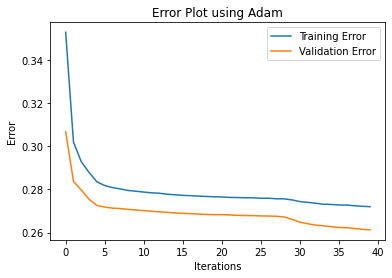

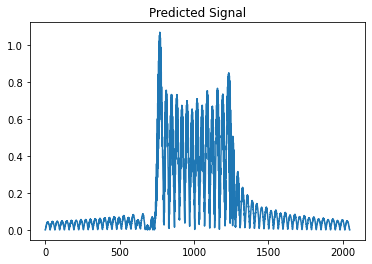

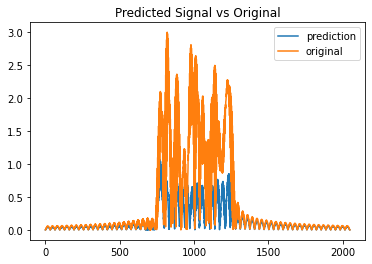

In [16]:
index_pred= 98
evals(clf, X_test, y_test, index_pred, opti, train_err, val_err)

### Bigger dataset

In [78]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
mlp_autoenc_like = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [79]:
mlp_autoenc_like.add(Dense(512, input_shape=(n_features,)))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(256))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(64))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(256))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(512))
mlp_autoenc_like.add(Activation('selu'))
mlp_autoenc_like.add(Dropout(0.25))
mlp_autoenc_like.add(BatchNormalization())

mlp_autoenc_like.add(Dense(n_output))
mlp_autoenc_like.add(Activation('selu'))

print ()
mlp_autoenc_like.summary(name="MLP-autoencoder-like")


+----------------------+
| MLP-autoencoder-like |
+----------------------+
Input Shape: (2048,)
+--------------------+------------+--------------+
| Layer Type         | Parameters | Output Shape |
+--------------------+------------+--------------+
| Dense              | 1049088    | (512,)       |
| Activation (SELU)  | 0          | (512,)       |
| Dropout            | 0          | (512,)       |
| BatchNormalization | 1024       | (512,)       |
| Dense              | 131328     | (256,)       |
| Activation (SELU)  | 0          | (256,)       |
| Dropout            | 0          | (256,)       |
| BatchNormalization | 512        | (256,)       |
| Dense              | 16448      | (64,)        |
| Activation (SELU)  | 0          | (64,)        |
| Dropout            | 0          | (64,)        |
| BatchNormalization | 128        | (64,)        |
| Dense              | 16640      | (256,)       |
| Activation (SELU)  | 0          | (256,)       |
| Dropout            | 0          | 

In [81]:
num_epochs = 40
batch_size = 128

In [82]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err_autoenc_lik, val_err_autoenc_lik = mlp_autoenc_like.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  128
[INFO] Training epochs number :  40


[INFO] Training loss on epoch  1  :  0.27638
[INFO] Validation loss on epoch  1  :  0.24950
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.25448
[INFO] Validation loss on epoch  2  :  0.24095
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.24863
[INFO] Validation loss on epoch  3  :  0.23584
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.24511
[INFO] Validation loss on epoch  4  :  0.23240
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.24256
[INFO] Validation loss on epoch  5  :  0.22953
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.24046
[INFO] Validation loss on epoch  6  :  0.22715
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.23865
[INFO] Validation loss on epoch  7  :  0.22509
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.23723
[INFO] Validation loss on epoch  8  :  0.22348
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.23595
[INFO] Validation loss on epoch  9  :  0.22183
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.23471
[INFO] Validation loss on epoch  10  :  0.22043
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.23357
[INFO] Validation loss on epoch  11  :  0.21921
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.23267
[INFO] Validation loss on epoch  12  :  0.21814
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.23162
[INFO] Validation loss on epoch  13  :  0.21705
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.23081
[INFO] Validation loss on epoch  14  :  0.21616
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.23009
[INFO] Validation loss on epoch  15  :  0.21545
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.22922
[INFO] Validation loss on epoch  16  :  0.21434
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.22878
[INFO] Validation loss on epoch  17  :  0.21357
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.22805
[INFO] Validation loss on epoch  18  :  0.21315
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.22749
[INFO] Validation loss on epoch  19  :  0.21229
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.22683
[INFO] Validation loss on epoch  20  :  0.21158
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.22620
[INFO] Validation loss on epoch  21  :  0.21087
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.22559
[INFO] Validation loss on epoch  22  :  0.21026
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.22510
[INFO] Validation loss on epoch  23  :  0.20983
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.22457
[INFO] Validation loss on epoch  24  :  0.20888
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.22405
[INFO] Validation loss on epoch  25  :  0.20832
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.22359
[INFO] Validation loss on epoch  26  :  0.20776
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.22322
[INFO] Validation loss on epoch  27  :  0.20713
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.22285
[INFO] Validation loss on epoch  28  :  0.20666
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.22225
[INFO] Validation loss on epoch  29  :  0.20634
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.22179
[INFO] Validation loss on epoch  30  :  0.20585
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.22145
[INFO] Validation loss on epoch  31  :  0.20519
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.22110
[INFO] Validation loss on epoch  32  :  0.20443
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.22060
[INFO] Validation loss on epoch  33  :  0.20400
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.22025
[INFO] Validation loss on epoch  34  :  0.20366
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.21992
[INFO] Validation loss on epoch  35  :  0.20311
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.21941
[INFO] Validation loss on epoch  36  :  0.20259
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.21912
[INFO] Validation loss on epoch  37  :  0.20218
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.21882
[INFO] Validation loss on epoch  38  :  0.20188
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.21849
[INFO] Validation loss on epoch  39  :  0.20150
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.21824
[INFO] Validation loss on epoch  40  :  0.20117
-------------------------------------------------------------------------------


### Testing

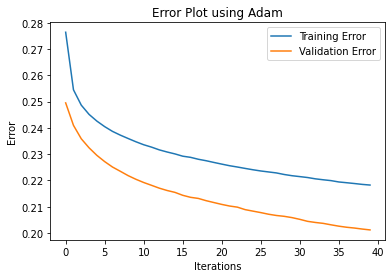

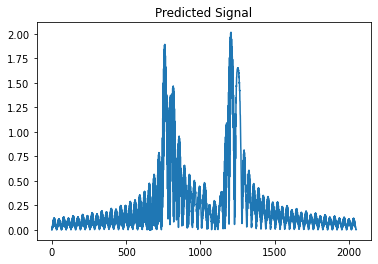

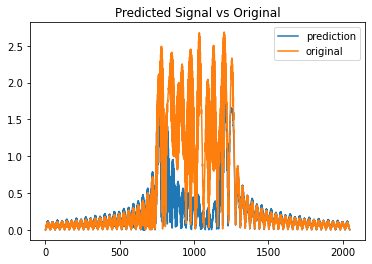

In [84]:
index_pred= 98
evals(mlp_autoenc_like, X_test, y_test, index_pred, opti, train_err_autoenc_lik, val_err_autoenc_lik)

## Train Con2D simple

In [27]:
num_epochs = 10
batch_size = 32

In [28]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  32
[INFO] Training epochs number :  10


[INFO] Training loss on epoch  1  :  0.46162
[INFO] Validation loss on epoch  1  :  0.62825
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.38110
[INFO] Validation loss on epoch  2  :  0.36889
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.35000
[INFO] Validation loss on epoch  3  :  0.32711
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.33816
[INFO] Validation loss on epoch  4  :  0.31680
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.33085
[INFO] Validation loss on epoch  5  :  0.31323
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.32529
[INFO] Validation loss on epoch  6  :  0.31138
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.32103
[INFO] Validation loss on epoch  7  :  0.31039
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.31825
[INFO] Validation loss on epoch  8  :  0.30951
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.31598
[INFO] Validation loss on epoch  9  :  0.30862
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.31362
[INFO] Validation loss on epoch  10  :  0.30755
-------------------------------------------------------------------------------


### Evaluation

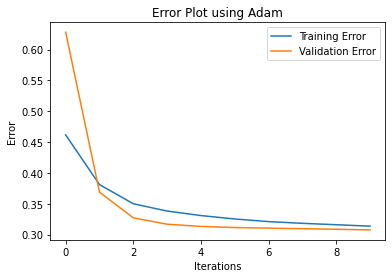

In [31]:
# Training and validation error plot
n = len(train_err)
training, = plt.plot(range(n), train_err, label="Training Error")
validation, = plt.plot(range(n), val_err, label="Validation Error")
plt.legend(handles=[training, validation])
plt.title("Error Plot using "+str(opti))
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

In [32]:
_, loss = clf.test_on_batch(X_test, y_test)
print ("Test loss:", loss)

Test loss: 0


### Testing the Conv2D

In [34]:
x_tester = X_test.reshape(X_test.shape[0], -1, 2,32,32)
x_test_original = X_test.reshape(X_test.shape[0], 2048,1)

In [35]:
index_pred = 54

[[0.04409289 0.00688274 0.04464493 ... 0.06249855 0.03349153 0.05991256]]


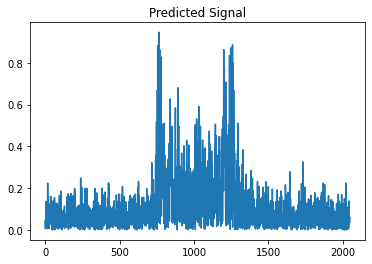

In [36]:
y_pred = clf.predict(x_tester[index_pred])
print(y_pred)
plt.title("Predicted Signal")
plt.plot(np.squeeze(np.abs(y_pred)))
plt.show()

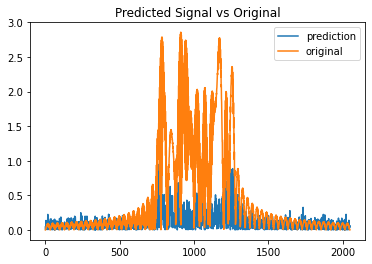

In [37]:
plt.title("Predicted Signal vs Original")
plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
plt.legend()
plt.show()

In [38]:
print ("max val :", np.max(y_pred))
print ("shape  :", y_pred.shape)

max val : 0.9467448413274234
shape  : (1, 2048)


## More deep Conv2D

In [50]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
model_deep = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [51]:
model_deep.add(Conv2D(n_filters=128, filter_shape=(3,3), stride=1, input_shape=(2,32,32), padding='same'))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.25))
model_deep.add(BatchNormalization())

model_deep.add(Conv2D(n_filters=64, filter_shape=(3,3), stride=1, padding='same'))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.25))
model_deep.add(BatchNormalization())

model_deep.add(Flatten())

model_deep.add(Dense(32))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.4))
model_deep.add(BatchNormalization())

model_deep.add(Dense(16))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.4))
model_deep.add(BatchNormalization())

model_deep.add(Dense(32))
model_deep.add(Activation('selu'))
model_deep.add(Dropout(0.4))
model_deep.add(BatchNormalization())

model_deep.add(Dense(n_output))
model_deep.add(Activation('selu'))
print ()
model_deep.summary(name="Conv2D-deep")


+-------------+
| Conv2D-deep |
+-------------+
Input Shape: (2, 32, 32)
+--------------------+------------+---------------+
| Layer Type         | Parameters | Output Shape  |
+--------------------+------------+---------------+
| Conv2D             | 2432       | (128, 32, 32) |
| Activation (SELU)  | 0          | (128, 32, 32) |
| Dropout            | 0          | (128, 32, 32) |
| BatchNormalization | 262144     | (128, 32, 32) |
| Conv2D             | 73792      | (64, 32, 32)  |
| Activation (SELU)  | 0          | (64, 32, 32)  |
| Dropout            | 0          | (64, 32, 32)  |
| BatchNormalization | 131072     | (64, 32, 32)  |
| Flatten            | 0          | (65536,)      |
| Dense              | 2097184    | (32,)         |
| Activation (SELU)  | 0          | (32,)         |
| Dropout            | 0          | (32,)         |
| BatchNormalization | 64         | (32,)         |
| Dense              | 528        | (16,)         |
| Activation (SELU)  | 0          | (16,) 

### Training the model

In [52]:
num_epochs = 5
batch_size = 4

In [ ]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = model_deep.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  4
[INFO] Training epochs number :  5
